In [274]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as sched

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

from matplotlib import pyplot as plt
import pickle

In [275]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

### Parameters

In [276]:
batch_size = 1000
epoch = 5
weight_decay = 1e-4
lr = 1e-3

In [277]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Lambda(lambda t: (t * 2) - 1)
])

In [278]:
full_DS = ImageFolder(root="trafic_32", transform=transform)
full_loader = DataLoader(dataset=full_DS, pin_memory=True, num_workers=0, shuffle=True, batch_size=batch_size)

len(full_DS)

39209

In [279]:
# classes_elem_cnt = {}
# for i in range(len(full_DS)):

#     x = full_DS[i][1]

#     if (x in classes_elem_cnt.keys()):
#         classes_elem_cnt[x] += 1

#     else:
#         classes_elem_cnt[x] = 1

#     # if (i%10==0):
# print(classes_elem_cnt)

# with open('classes_member_cnt.pkl', 'wb') as file:
#     pickle.dump(classes_elem_cnt, file)


In [280]:
with open('classes_member_cnt.pkl', 'rb') as file:
    pickle.load(file)

In [281]:
class Unet_Block(nn.Module):
    """
    Base U-Net block
    in_channels - number of input channels
    out_channels - number of out channels
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.activation = nn.SiLU()

        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=(1,1)),
            self.activation,
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=(1,1)),
            self.activation,
            nn.BatchNorm2d(out_channels) # to moze na GN zmienic
        ])

    def forward(self, x):

        for layer in self.layers:
            x = layer(x)

        return x

In [282]:
class Rescaler(nn.Module):
    """
    Resacler either upscales given input or downscales it (size x2 or /2 only)
    """

    def __init__(self, in_channels, out_channels, upscale:bool):
        super().__init__()

        if upscale:
            self.rescaler = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=(2,2))
        else:
            self.rescaler = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=(2,2))

    def forward(self, x):
        return self.rescaler(x)

In [283]:
class U_Net(nn.Module):

    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.num_classes = num_classes

        self.encoder = nn.ModuleList([

            Unet_Block(in_channels, 32), # +1 in channel zeby warunkowac klasą
            Rescaler(32, 32, upscale=False), # 16x16

            Unet_Block(32, 64),
            Rescaler(64, 64, upscale=False), #8x8

            Unet_Block(64, 128),
            Rescaler(128, 128, upscale=False), #4x4

            Unet_Block(128, 172),
            Rescaler(172, 172, upscale=False), # 2x2
        ])

        self.latent = nn.Sequential(
            nn.Conv2d(in_channels=172, out_channels=226, kernel_size=3, padding=1, stride=1),
            nn.SiLU(),
            nn.Conv2d(in_channels=226, out_channels=226, kernel_size=3, padding=1, stride=1),
            nn.SiLU(),
            nn.BatchNorm2d(226)
        )

        self.decoder = nn.ModuleList([

            Rescaler(226, 226, upscale=True), # 4x4
            Unet_Block(398, 172), # 226 + 172(res)

            Rescaler(172, 172, upscale=True), #8x8
            Unet_Block(300, 128), #(172 + 128)

            Rescaler(128, 128, upscale=True), #16x16
            Unet_Block(192, 64), #(128 + 64)

            Rescaler(64, 64, upscale=True), # 32x32
            Unet_Block(96, 32), #(64 + 32)

            nn.Conv2d(in_channels=32, out_channels=in_channels, kernel_size=1, stride=1, padding=0)

        ])

    def forward(self, x):  # opcjonalnie dodac noise amount
        residual = []

        # encoder
        for idx, layer in enumerate(self.encoder):
            x = layer(x)

            if(idx%2 == 0):
                residual.append(x)
        residual.reverse()

        # latent
        x = self.latent(x)

        # decoder
        for idx, layer in enumerate(self.decoder):
            x = layer(x)

            if(idx%2 == 0 and idx <= 6): # idx<=6, bo na idx=8 jest convm, ktory nie dostaje rezyduala
                x = torch.cat([x, residual[int(idx/2)]], dim=1) # (B, CH, H, W) - dim=1

        return x

In [284]:
model = U_Net(3, 10)
model.to(device)

U_Net(
  (encoder): ModuleList(
    (0): Unet_Block(
      (activation): SiLU()
      (layers): ModuleList(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): SiLU()
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): SiLU()
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Rescaler(
      (rescaler): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    )
    (2): Unet_Block(
      (activation): SiLU()
      (layers): ModuleList(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): SiLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): SiLU()
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Rescaler(
      (rescaler): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    )
    (4): Unet_Block(


In [285]:
params_sum = 0
for params in model.parameters():
    params_sum+=params.view(-1).size(0)
params_sum

3734297

In [286]:
optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay, lr=lr)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)
loss_fn = nn.MSELoss()

In [287]:
#TODO noise sched + trening

In [288]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x) # to zmienic na randn_like - rozkłąd gaussa + dodac resize obrazkó do -1,1
    amount = amount.view(-1, 1, 1, 1)  # Ensure shape compatibility for broadcasting
    return x * (1 - amount) + noise * amount


In [289]:
def one_hot_encode(value, num_classes):
    """used to encode class of the image before feeding it to the model"""
    OHE = torch.eye(num_classes)[value]
    return OHE

In [290]:
img, y = next(iter(full_loader))
img = img[:4, :,:,:]

In [291]:
### OHE encoding of classed and caoncating with input image

# Function for one-hot encoding a label vector
def one_hot_encode_vector(labels, num_classes):
    return torch.eye(num_classes)[labels]

# Example label vector and number of classes
label_vector = torch.tensor([0, 3, 5, 2])  # Example label vector
num_classes = 43  # Number of classes (0 to 42)

# One-hot encode the label vector
encoded_labels = one_hot_encode_vector(label_vector, num_classes)
print(encoded_labels.shape[0])

# Reshape the one-hot encoded labels to match the image dimensions
reshaped_labels = encoded_labels.view(-1, 1, 1, num_classes)
print(reshaped_labels.shape[2])

# Repeat the label tensor to match the number of channels in the image tensor
repeated_labels = reshaped_labels.repeat(1, 32, 32, 1)  # Assuming 32x32 images with 3 channels
print(repeated_labels.shape[3])

# Assuming your image tensor is named 'image_tensor' with shape (batch_size, channels, height, width)
# Now, you can concatenate the repeated and reshaped labels with your image tensor
concatenated_tensor = torch.cat((img, repeated_labels.permute(0, 3, 1, 2)), dim=1)  # Permute for channel-first format


4
1
43


In [292]:
img, y = next(iter(full_loader))
img = img[:24, :,:,:]

In [293]:
# reverse_transform = transforms.Lambda(lambda t: (t + 1) / 2) # used to denormalize

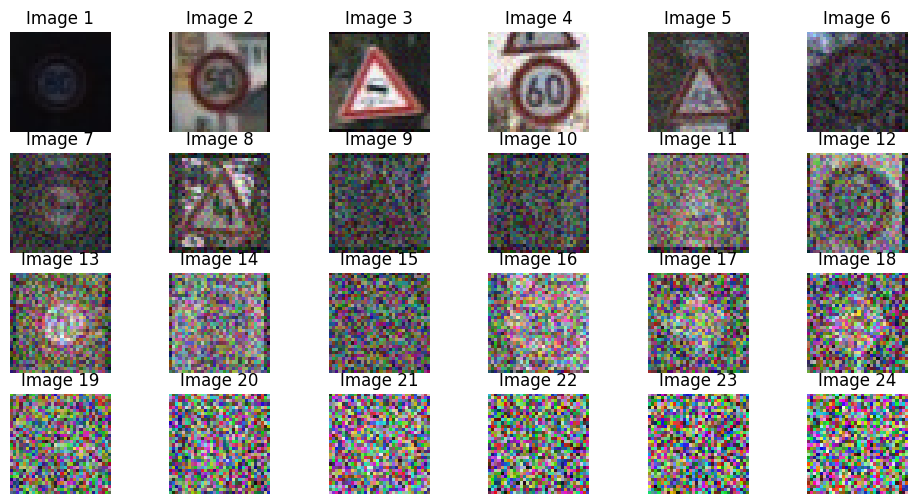

In [294]:
img, y = next(iter(full_loader))
img = img[:24, :,:,:]
x=img
# x = reverse_transform(x)

amount = torch.linspace(0, 1, x.shape[0])
x = corrupt(x, amount)
x = x.detach().cpu().numpy()

fig, axes = plt.subplots(4, 6, figsize=(12, 6))  # Assuming batch_size is at least 8
for i in range(4):
    for j in range(6):
        index = i * 6 + j
        axes[i, j].imshow(x[index].transpose(1, 2, 0))  # Assuming the channel dimension is second
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Image {index + 1}')

plt.show()

In [295]:
losses = []

model.train()

for epoch in range(epoch):

    for x, y in full_loader:

        x = x.to(device)  # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device)  # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount)  # Create our noisy x

        # Get the model prediction
        pred = model(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x)  # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(full_loader) :]) / len(full_loader)
    print(f"Finished epoch {epoch+1}. Average loss for this epoch: {avg_loss:05f}")

model.eval()

Finished epoch 0. Average loss for this epoch: 0.186470
Finished epoch 1. Average loss for this epoch: 0.088963
Finished epoch 2. Average loss for this epoch: 0.035620
Finished epoch 3. Average loss for this epoch: 0.016377
Finished epoch 4. Average loss for this epoch: 0.014905


U_Net(
  (encoder): ModuleList(
    (0): Unet_Block(
      (activation): SiLU()
      (layers): ModuleList(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): SiLU()
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): SiLU()
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Rescaler(
      (rescaler): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    )
    (2): Unet_Block(
      (activation): SiLU()
      (layers): ModuleList(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): SiLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): SiLU()
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Rescaler(
      (rescaler): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    )
    (4): Unet_Block(


(0.0, 0.1)

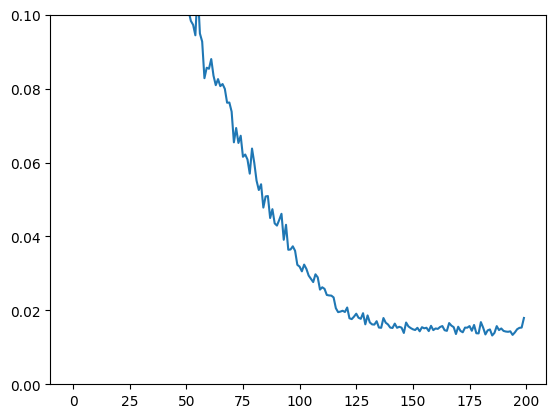

In [296]:
# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

In [ ]:
# @markdown Visualizing model predictions on noisy inputs:

# Fetch some data
x, y = next(iter(full_DS))
x = x[:8]  # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
    preds = model(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(-1, 1))
axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1))
axs[2].set_title("Network Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1))

torch.Size([209, 3, 32, 32])
209
209
209


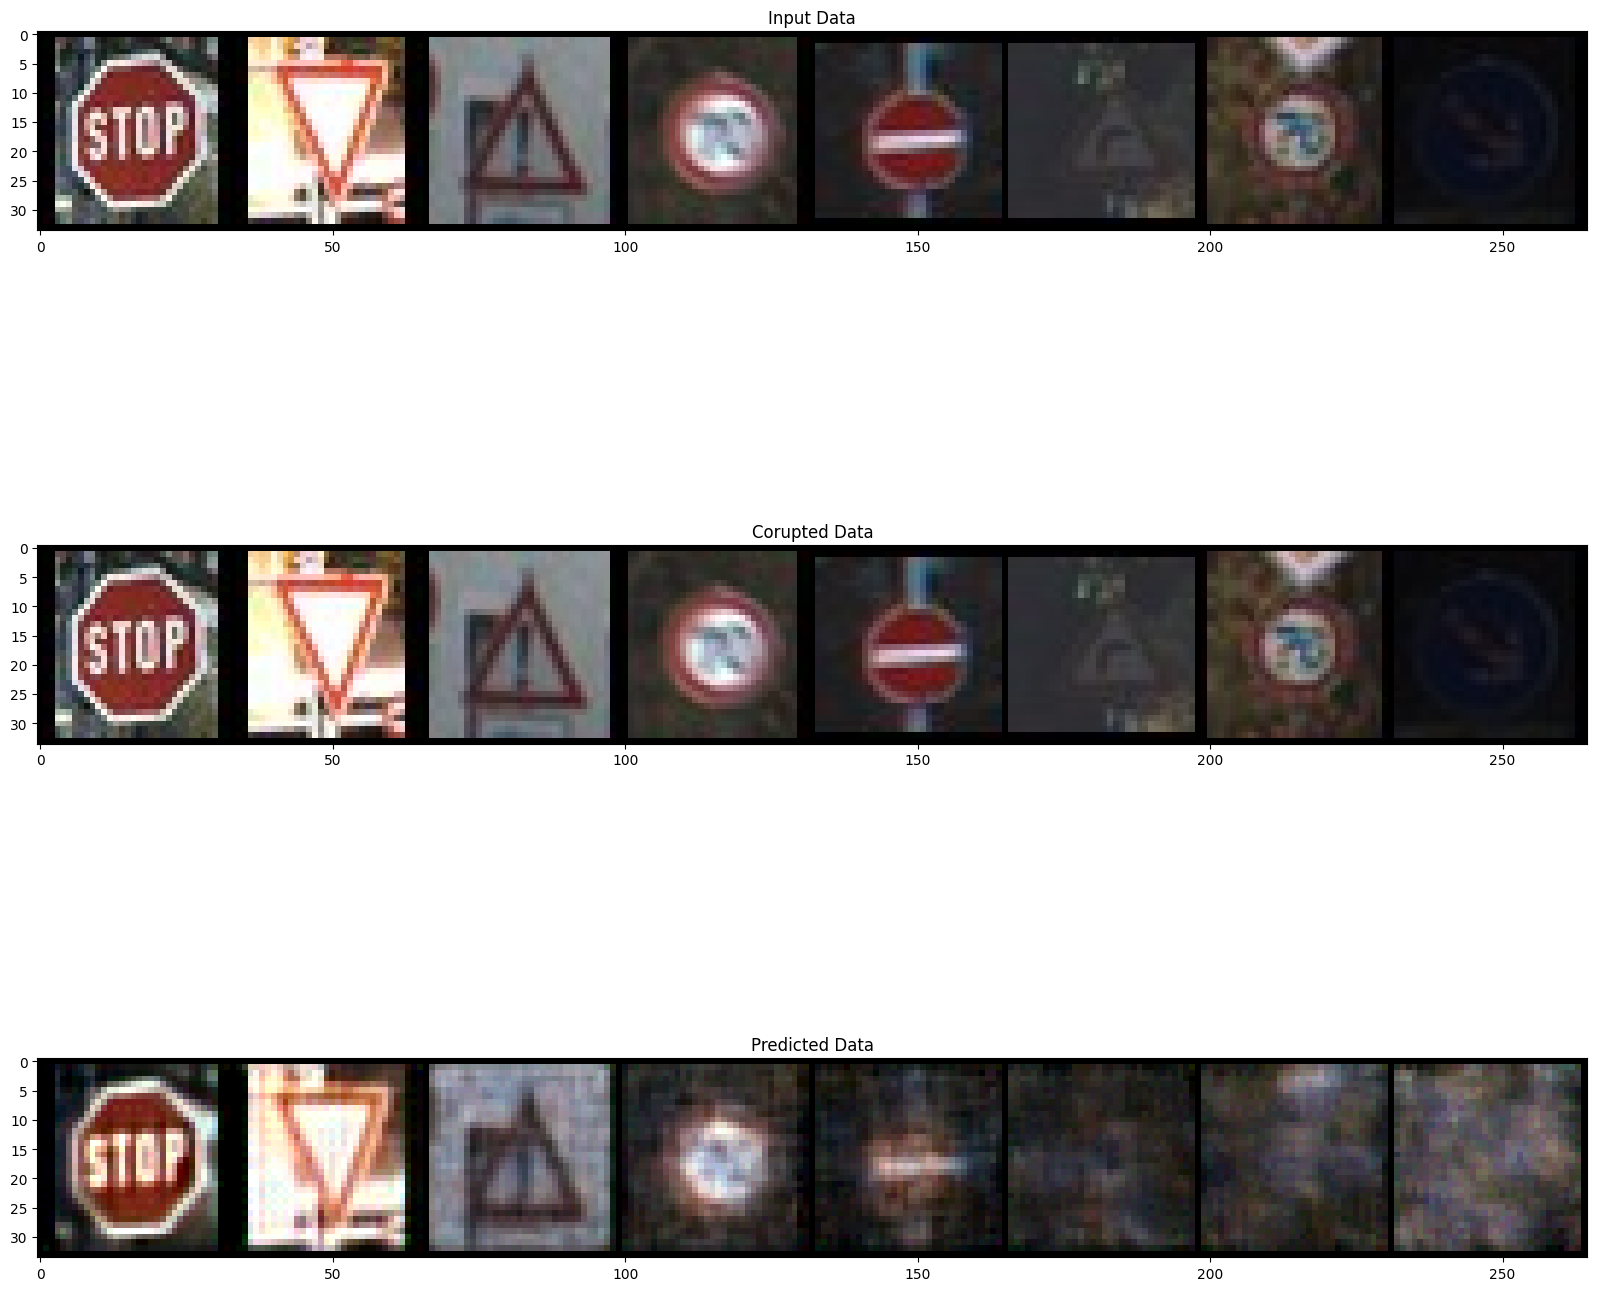

In [324]:
img, y = next(iter(full_loader))
img = img[:8, :,:,:]
x=img
# x = reverse_transform(x)

amount = torch.linspace(0, 1, x.shape[0])
x = x.detach().cpu()
noised_x = corrupt(x, amount)

with torch.no_grad():
    preds = model(noised_x.to(device)).detach().cpu()
    print(pred.shape)
    print(pred.shape[0])
    print(pred.shape[0])
    print(pred.shape[0])

fig, axs = plt.subplots(3, 1, figsize=(20, 20), gridspec_kw={'hspace': 0.001})
axs[0].set_title("Input Data")
axs[0].imshow(torchvision.utils.make_grid(img, nrow=8, padding=2).permute(1, 2, 0).clip(0, 1))

axs[1].set_title("Corupted Data")
axs[1].imshow(torchvision.utils.make_grid(x, nrow=8, padding=2).permute(1, 2, 0).clip(0, 1))

axs[2].set_title("Predicted Data")
axs[2].imshow(torchvision.utils.make_grid(preds, nrow=8, padding=2).permute(1, 2, 0).clip(0, 1))
plt.show()